In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)
plt.rcParams['font.size'] = 10


In [2]:
df = pd.read_csv(Path('../data/PRSA_data_2010.1.1-2014.12.31_Beijing.csv'))

In [3]:
# Funzione per identificare sequenze continue senza missing
def find_continuous_sequences(series, min_length=100):
    """
    Identifica sequenze continue di valori non-missing di lunghezza >= min_length.
    
    Parameters:
    -----------
    series : pd.Series
        Serie temporale da analizzare
    min_length : int
        Lunghezza minima della sequenza continua
    
    Returns:
    --------
    list of tuples : [(start_idx, end_idx, length), ...]
        Lista di tuple con indici di inizio, fine e lunghezza di ogni sequenza
    """
    sequences = []
    start_idx = None
    current_length = 0
    
    for idx in range(len(series)):
        if pd.notna(series.iloc[idx]):
            # Valore valido
            if start_idx is None:
                start_idx = idx
                current_length = 1
            else:
                current_length += 1
        else:
            # Missing value - salva sequenza se abbastanza lunga
            if start_idx is not None and current_length >= min_length:
                sequences.append((start_idx, idx - 1, current_length))
            start_idx = None
            current_length = 0
    
    # Controlla l'ultima sequenza
    if start_idx is not None and current_length >= min_length:
        sequences.append((start_idx, len(series) - 1, current_length))
    
    return sequences

# Crea indice datetime
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.set_index('datetime', inplace=True)

# Trova sequenze continue di PM2.5
min_sequence_length = 100
continuous_sequences = find_continuous_sequences(df['pm2.5'], min_length=min_sequence_length)

print(f"\n SEQUENZE CONTINUE (≥ {min_sequence_length} valori consecutivi senza missing)\n")
print("=" * 90)
print(f"{'#':<5} {'Inizio':<22} {'Fine':<22} {'Lunghezza':<12} {'% Dataset':<12}")
print("=" * 90)

total_continuous_values = 0
for i, (start_idx, end_idx, length) in enumerate(continuous_sequences, 1):
    start_date = df.index[start_idx]
    end_date = df.index[end_idx]
    pct = length / len(df) * 100
    print(f"{i:<5} {str(start_date):<22} {str(end_date):<22} {length:<12,} {pct:<12.2f}%")
    total_continuous_values += length

print("=" * 90)
print(f"\nStatistiche:")
print(f"   Numero sequenze trovate:     {len(continuous_sequences)}")
print(f"   Totale valori in sequenze:   {total_continuous_values:,}")
print(f"   % dataset utilizzabile:      {total_continuous_values/len(df)*100:.2f}%")
print(f"   Media lunghezza sequenza:    {total_continuous_values/len(continuous_sequences):.0f} valori")
print(f"   Sequenza più lunga:          {max([s[2] for s in continuous_sequences]):,} valori")
print(f"   Sequenza più corta:          {min([s[2] for s in continuous_sequences]):,} valori")


 SEQUENZE CONTINUE (≥ 100 valori consecutivi senza missing)

#     Inizio                 Fine                   Lunghezza    % Dataset   
1     2010-01-02 00:00:00    2010-01-23 16:00:00    521          1.19        %
2     2010-01-26 12:00:00    2010-02-14 01:00:00    446          1.02        %
3     2010-02-14 03:00:00    2010-03-20 04:00:00    818          1.87        %
4     2010-03-23 00:00:00    2010-03-30 05:00:00    174          0.40        %
5     2010-04-01 13:00:00    2010-05-17 16:00:00    1,108        2.53        %
6     2010-05-17 19:00:00    2010-05-27 18:00:00    240          0.55        %
7     2010-05-28 00:00:00    2010-06-01 15:00:00    112          0.26        %
8     2010-06-09 17:00:00    2010-06-20 07:00:00    255          0.58        %
9     2010-06-23 10:00:00    2010-08-13 19:00:00    1,234        2.82        %
10    2010-08-16 16:00:00    2010-09-11 05:00:00    614          1.40        %
11    2010-09-11 22:00:00    2010-09-19 18:00:00    189          0.43 

In [4]:
# Estrai dati dalle sequenze continue
def extract_continuous_data(dataframe, sequences):
    """
    Estrae i dati dalle sequenze continue e li concatena.
    
    Parameters:
    -----------
    dataframe : pd.DataFrame
        DataFrame originale
    sequences : list of tuples
        Lista di sequenze (start_idx, end_idx, length)
    
    Returns:
    --------
    pd.DataFrame : DataFrame con solo le sequenze continue
    list : Lista di tuple (seq_id, start_pos, end_pos) per tracciare le sequenze
    """
    continuous_chunks = []
    sequence_info = []
    current_position = 0
    
    for seq_id, (start_idx, end_idx, length) in enumerate(sequences, 1):
        chunk = dataframe.iloc[start_idx:end_idx+1].copy()
        chunk['sequence_id'] = seq_id  # Traccia da quale sequenza proviene
        continuous_chunks.append(chunk)
        
        # Salva informazioni sulla posizione nel nuovo dataset
        sequence_info.append({
            'seq_id': seq_id,
            'original_start': start_idx,
            'original_end': end_idx,
            'new_start': current_position,
            'new_end': current_position + length - 1,
            'length': length,
            'date_start': dataframe.index[start_idx],
            'date_end': dataframe.index[end_idx]
        })
        current_position += length
    
    # Concatena tutte le sequenze
    continuous_df = pd.concat(continuous_chunks, axis=0)
    
    return continuous_df, sequence_info

# Estrai dati continui
df_continuous, seq_info = extract_continuous_data(df, continuous_sequences)

print("Dataset Continuo Estratto\n")
print("=" * 90)
print(f"Shape dataset originale:    {df.shape}")
print(f"Shape dataset continuo:     {df_continuous.shape}")
print(f"Righe mantenute:            {len(df_continuous):,} ({len(df_continuous)/len(df)*100:.2f}%)")
print("=" * 90)

print(f"\nInformazioni Sequenze nel Dataset Continuo:")
print("=" * 90)
print(f"{'Seq':<5} {'Inizio Originale':<20} {'Fine Originale':<20} {'Pos. Nuovo Dataset':<25} {'Lunghezza':<12}")
print("=" * 90)
for info in seq_info:
    pos_range = f"{info['new_start']} - {info['new_end']}"
    print(f"{info['seq_id']:<5} {str(info['date_start']):<20} {str(info['date_end']):<20} "
          f"{pos_range:<25} {info['length']:<12,}")
print("=" * 90)

# Verifica che non ci siano missing nel dataset continuo
missing_in_continuous = df_continuous['pm2.5'].isnull().sum()
print(f"\nVerifica: Missing PM2.5 nel dataset continuo: {missing_in_continuous}")

Dataset Continuo Estratto

Shape dataset originale:    (43824, 13)
Shape dataset continuo:     (38471, 14)
Righe mantenute:            38,471 (87.79%)

Informazioni Sequenze nel Dataset Continuo:
Seq   Inizio Originale     Fine Originale       Pos. Nuovo Dataset        Lunghezza   
1     2010-01-02 00:00:00  2010-01-23 16:00:00  0 - 520                   521         
2     2010-01-26 12:00:00  2010-02-14 01:00:00  521 - 966                 446         
3     2010-02-14 03:00:00  2010-03-20 04:00:00  967 - 1784                818         
4     2010-03-23 00:00:00  2010-03-30 05:00:00  1785 - 1958               174         
5     2010-04-01 13:00:00  2010-05-17 16:00:00  1959 - 3066               1,108       
6     2010-05-17 19:00:00  2010-05-27 18:00:00  3067 - 3306               240         
7     2010-05-28 00:00:00  2010-06-01 15:00:00  3307 - 3418               112         
8     2010-06-09 17:00:00  2010-06-20 07:00:00  3419 - 3673               255         
9     2010-06-23 10:0

In [5]:
# Funzione per creare finestre temporali (sliding window)
def create_sequences_from_continuous(data, sequence_info, window_size=24, forecast_horizon=1, 
                                     features=None, target='pm2.5'):
    """
    Crea finestre temporali dalle sequenze continue, rispettando i confini delle sequenze.
    
    Parameters:
    -----------
    data : pd.DataFrame
        DataFrame con le sequenze continue
    sequence_info : list of dict
        Informazioni sulle sequenze
    window_size : int
        Dimensione della finestra di input (numero di timesteps passati)
    forecast_horizon : int
        Orizzonte di previsione (numero di timesteps futuri da predire)
    features : list
        Lista di feature da usare (se None, usa tutte tranne target)
    target : str
        Nome della colonna target
    
    Returns:
    --------
    X : np.array
        Array di input shape (n_samples, window_size, n_features)
    y : np.array
        Array di target shape (n_samples, forecast_horizon)
    window_info : list
        Informazioni su ogni finestra (per debugging/analisi)
    """
    if features is None:
        # Usa tutte le feature tranne target e sequence_id
        features = [col for col in data.columns if col not in [target, 'sequence_id']]
    
    X_list = []
    y_list = []
    window_info = []
    
    total_windows = 0
    
    # Processa ogni sequenza separatamente
    for seq in sequence_info:
        seq_id = seq['seq_id']
        start_pos = seq['new_start']
        end_pos = seq['new_end']
        seq_length = seq['length']
        
        # Estrai dati della sequenza
        seq_data = data.iloc[start_pos:end_pos+1]
        
        # Calcola quante finestre possiamo creare da questa sequenza
        max_windows = seq_length - window_size - forecast_horizon + 1
        
        if max_windows <= 0:
            print(f"Sequenza {seq_id} troppo corta ({seq_length}) per creare finestre "
                  f"(necessari almeno {window_size + forecast_horizon})")
            continue
        
        # Crea finestre dalla sequenza
        for i in range(max_windows):
            # Finestra di input
            window_start = i
            window_end = i + window_size
            
            # Valore/i da predire
            target_start = window_end
            target_end = window_end + forecast_horizon
            
            # Estrai dati
            X_window = seq_data[features].iloc[window_start:window_end].values
            y_window = seq_data[target].iloc[target_start:target_end].values
            
            # Verifica che non ci siano NaN (controlla solo se numeric)
            has_nan = False
            try:
                has_nan = np.isnan(X_window).any() or np.isnan(y_window).any()
            except TypeError:
                # Se non è numerico, usa pandas
                has_nan = pd.isna(X_window).any() or pd.isna(y_window).any()
            
            if not has_nan:
                X_list.append(X_window)
                y_list.append(y_window)
                
                window_info.append({
                    'seq_id': seq_id,
                    'window_idx': i,
                    'global_start': start_pos + window_start,
                    'global_end': start_pos + window_end - 1,
                    'target_idx': start_pos + target_start
                })
                
                total_windows += 1
        
        print(f"✓ Sequenza {seq_id}: {max_windows:,} finestre create")
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"\nRiepilogo Windowing:")
    print(f"   Finestre totali create:  {total_windows:,}")
    print(f"   X shape:                 {X.shape} (samples, timesteps, features)")
    print(f"   y shape:                 {y.shape} (samples, forecast_horizon)")
    
    return X, y, window_info


In [6]:
# Parametri windowing
WINDOW_SIZE = 100  # Usa 100 valori precedenti di PM2.5
FORECAST_HORIZON = 1  # Predici il prossimo valore

feature_columns = ['pm2.5']  # Solo PM2.5!

In [7]:
# Crea finestre temporali
X, y, window_info = create_sequences_from_continuous(
    data=df_continuous,
    sequence_info=seq_info,
    window_size=WINDOW_SIZE,
    forecast_horizon=FORECAST_HORIZON,
    features=['pm2.5'],  # Solo PM2.5 come input!
    target='pm2.5'
)

print("=" * 90)
print(f"\nShape finali:")
print(f"   X: {X.shape} → (n_samples={X.shape[0]:,}, timesteps={X.shape[1]}, features={X.shape[2]})")
print(f"   y: {y.shape} → (n_samples={y.shape[0]:,}, forecast_horizon={y.shape[1]})")

✓ Sequenza 1: 421 finestre create
✓ Sequenza 2: 346 finestre create
✓ Sequenza 3: 718 finestre create
✓ Sequenza 4: 74 finestre create
✓ Sequenza 5: 1,008 finestre create
✓ Sequenza 6: 140 finestre create
✓ Sequenza 7: 12 finestre create
✓ Sequenza 8: 155 finestre create
✓ Sequenza 5: 1,008 finestre create
✓ Sequenza 6: 140 finestre create
✓ Sequenza 7: 12 finestre create
✓ Sequenza 8: 155 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 9: 1,134 finestre create
✓ Sequenza 10: 514 finestre create
✓ Sequenza 11: 89 finestre create
✓ Sequenza 12: 181 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 13: 373 finestre create
✓ Sequenza 14: 352 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓ Sequenza 15: 847 finestre create
✓ Sequenza 16: 60 finestre create
✓ Sequenza 17: 1,224 finestre cre

In [8]:
# Split Train/Val/Test a livello di sequenze intere
# Bilanciato per numero di FINESTRE (non sequenze)
# Proporzione: 60% Train / 19% Validation / 21% Test

# 1. Conta quante finestre ha ogni sequenza
from collections import defaultdict
windows_per_sequence = defaultdict(int)

for win_info in window_info:
    seq_id = win_info['seq_id']
    windows_per_sequence[seq_id] += 1

total_windows = len(window_info)

# 2. Assegnazione greedy delle sequenze per avvicinarsi al 60/20/20
target_train_windows = int(0.60 * total_windows)
target_val_windows = int(0.18 * total_windows)
# Il resto va automaticamente al test

# Shuffle casuale delle sequenze
np.random.seed(17)
sequence_ids = list(windows_per_sequence.keys())
np.random.shuffle(sequence_ids)

train_sequences = []
val_sequences = []
test_sequences = []
train_window_count = 0
val_window_count = 0

# Assegna sequenze ai tre split
for seq_id in sequence_ids:
    if train_window_count < target_train_windows:
        # Aggiungi a train
        train_sequences.append(seq_id)
        train_window_count += windows_per_sequence[seq_id]
    elif val_window_count < target_val_windows:
        # Aggiungi a validation
        val_sequences.append(seq_id)
        val_window_count += windows_per_sequence[seq_id]
    else:
        # Aggiungi a test
        test_sequences.append(seq_id)

print(f"\nAssegnazione sequenze in train/val/test:")
print(f"   Train:      {len(train_sequences)} sequenze → {sorted(train_sequences)}")
print(f"   Validation: {len(val_sequences)} sequenze → {sorted(val_sequences)}")
print(f"   Test:       {len(test_sequences)} sequenze → {sorted(test_sequences)}")

# 3. Raccogli indici delle finestre
train_indices = []
val_indices = []
test_indices = []

for idx, win_info in enumerate(window_info):
    if win_info['seq_id'] in train_sequences:
        train_indices.append(idx)
    elif win_info['seq_id'] in val_sequences:
        val_indices.append(idx)
    else:
        test_indices.append(idx)

# 4. Estrai i dati
X_train = X[train_indices]
y_train = y[train_indices]
X_val = X[val_indices]
y_val = y[val_indices]
X_test = X[test_indices]
y_test = y[test_indices]

print(f"\nPercentuali finestre:")
print(f"   Train:      {len(X_train):,} finestre ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation: {len(X_val):,} finestre ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test:       {len(X_test):,} finestre ({len(X_test)/len(X)*100:.1f}%)")

# Normalizzazione
from sklearn.preprocessing import StandardScaler

# Reshape per normalizzazione
n_train_samples, n_timesteps, n_features = X_train.shape
X_train_reshaped = X_train.reshape(-1, n_features)

n_val_samples = X_val.shape[0]
X_val_reshaped = X_val.reshape(-1, n_features)

n_test_samples = X_test.shape[0]
X_test_reshaped = X_test.reshape(-1, n_features)

# Fit scaler solo sul training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

# Reshape back
X_train_scaled = X_train_scaled.reshape(n_train_samples, n_timesteps, n_features)
X_val_scaled = X_val_scaled.reshape(n_val_samples, n_timesteps, n_features)
X_test_scaled = X_test_scaled.reshape(n_test_samples, n_timesteps, n_features)

print(f"\nNormalizzazione:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_val_scaled:   {X_val_scaled.shape}")
print(f"   X_test_scaled:  {X_test_scaled.shape}")

print(f"\nStatistiche target (PM2.5):")
print(f"   Train - min: {y_train.min():.2f}, max: {y_train.max():.2f}, mean: {y_train.mean():.2f}")
print(f"   Val   - min: {y_val.min():.2f}, max: {y_val.max():.2f}, mean: {y_val.mean():.2f}")
print(f"   Test  - min: {y_test.min():.2f}, max: {y_test.max():.2f}, mean: {y_test.mean():.2f}")


Assegnazione sequenze in train/val/test:
   Train:      49 sequenze → [1, 5, 10, 12, 13, 15, 17, 19, 21, 23, 26, 27, 28, 30, 31, 35, 36, 37, 38, 39, 42, 45, 48, 49, 50, 54, 55, 61, 62, 64, 66, 67, 68, 69, 72, 73, 75, 77, 78, 79, 80, 84, 85, 88, 89, 90, 91, 92, 96]
   Validation: 18 sequenze → [3, 6, 9, 14, 20, 25, 29, 44, 52, 53, 56, 57, 60, 71, 74, 76, 81, 87]
   Test:       28 sequenze → [2, 4, 7, 8, 11, 16, 18, 24, 32, 33, 34, 40, 41, 43, 46, 47, 51, 58, 59, 63, 65, 70, 82, 83, 86, 93, 94, 95]

Percentuali finestre:
   Train:      17,340 finestre (60.1%)
   Validation: 5,327 finestre (18.5%)
   Test:       6,204 finestre (21.5%)

Normalizzazione:
   X_train_scaled: (17340, 100, 1)
   X_val_scaled:   (5327, 100, 1)
   X_test_scaled:  (6204, 100, 1)

Statistiche target (PM2.5):
   Train - min: 2.00, max: 994.00, mean: 95.86
   Val   - min: 2.00, max: 700.00, mean: 107.63
   Test  - min: 1.00, max: 980.00, mean: 93.80


# GRU Model with Hyperparameter Optimization

Implementazione di **Gated Recurrent Unit (GRU)** per previsione PM2.5 con ottimizzazione Optuna.

In [9]:
# Installa Optuna se necessario
try:
    import optuna
    from optuna.pruners import MedianPruner
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "optuna", "-q"])
    import optuna
    from optuna.pruners import MedianPruner

print(f"Optuna version: {optuna.__version__}")

Optuna version: 4.6.0


In [ ]:
# Configura paths per salvataggio modelli
models_dir = Path('../models')
models_dir.mkdir(exist_ok=True)

gru_model_path = models_dir / 'gru_pm25_forecaster_fixed_dropout.h5'
gru_config_path = models_dir / 'gru_best_params_fixed_dropout.pkl'
gru_history_path = models_dir / 'gru_training_history_fixed_dropout.pkl'

print(f"Paths configurati:")
print(f"   GRU model: {gru_model_path.name}")
print(f"   GRU config: {gru_config_path.name}")
print(f"   GRU history: {gru_history_path.name}")

Paths configurati:
   GRU model: gru_pm25_forecaster.h5
   GRU config: gru_best_params.pkl
   GRU history: gru_training_history.pkl


In [11]:
def create_gru_model(units, dropout, learning_rate, n_layers, input_shape):
    """
    Crea modello GRU per time series forecasting.
    
    Parameters:
    -----------
    units : int
        Numero di unità GRU
    dropout : float
        Dropout rate
    learning_rate : float
        Learning rate per Adam optimizer
    n_layers : int
        Numero di layer GRU da impilare
    input_shape : tuple
        (timesteps, features)
    
    Returns:
    --------
    model : keras.Model
        Modello GRU compilato
    """
    model = keras.Sequential()
    
    # Primo layer
    if n_layers == 1:
        model.add(keras.layers.GRU(units, dropout=dropout, input_shape=input_shape))
    else:
        model.add(keras.layers.GRU(units, dropout=dropout, return_sequences=True, input_shape=input_shape))
        
        # Layer intermedi
        for i in range(1, n_layers - 1):
            model.add(keras.layers.GRU(units, dropout=dropout, return_sequences=True))
        
        # Ultimo layer
        model.add(keras.layers.GRU(units, dropout=dropout))
    
    # Output layer
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model
    

In [ ]:
def gru_objective(trial):
    """
    Objective function per Optuna - GRU
    Griglia ridotta per velocità
    """
    # Spazio di ricerca LIMITATO
    params = {
        'units': trial.suggest_categorical('units', [32, 64, 128]),
        'dropout': trial.suggest_float('dropout', 0, 0.5),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'n_layers': trial.suggest_int('n_layers', 1, 3)  # 1-3 layer GRU
    }
    
    # Crea modello
    model = create_gru_model(
        units=params['units'],
        dropout=0.1,#params['dropout'],
        learning_rate=params['learning_rate'],
        n_layers=params['n_layers'],
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
    )
    
    # Early stopping
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    # Training veloce (max 30 epochs)
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )
    
    # Ritorna best validation loss
    best_val_loss = min(history.history['val_loss'])
    

    return best_val_loss

In [ ]:
# Ottimizzazione GRU con Optuna (15 trials)

import pickle

if gru_config_path.exists():
    print("="*70)
    print("GRU: Best params esistenti - CARICAMENTO")
    print("="*70)
    
    with open(gru_config_path, 'rb') as f:
        gru_best_params = pickle.load(f)
    
    print("\nGRU Best hyperparameters:")
    for key, value in gru_best_params.items():
        print(f"   • {key}: {value}")
    print("="*70)
    
else:
    print("="*70)
    print("GRU: OTTIMIZZAZIONE HYPERPARAMETERS")
    print("="*70)
    print(f"   • Trials: 15")
    print(f"   • Max epochs per trial: 50")
    print(f"   • Early stopping: patience=5")
    print("="*70 + "\n")
    
    # Crea study
    study = optuna.create_study(
        study_name='gru_pm25',
        direction='minimize',
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=10)
    )
    
    # Ottimizza (15 trials)
    study.optimize(
        gru_objective,
        n_trials=15,
        timeout=None,
        show_progress_bar=True
    )
    
    print("\n" + "="*70)
    print("GRU: OTTIMIZZAZIONE COMPLETATA")
    print("="*70)
    
    gru_best_params = study.best_trial.params
    best_val_loss = study.best_trial.value
    
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    print("\nBest hyperparameters:")
    for key, value in gru_best_params.items():
        print(f"   • {key}: {value}")
    
    # Salva best params
    with open(gru_config_path, 'wb') as f:
        pickle.dump(gru_best_params, f)
    
    print(f"\nBest params salvati: {gru_config_path.name}")
    print("="*70)

[I 2025-12-11 17:59:44,770] A new study created in memory with name: gru_pm25


GRU: OTTIMIZZAZIONE HYPERPARAMETERS
   • Trials: 10
   • Max epochs per trial: 50
   • Early stopping: patience=5



Best trial: 0. Best value: 2340.34:  10%|█         | 1/10 [21:05<3:09:51, 1265.73s/it]

[I 2025-12-11 18:20:50,512] Trial 0 finished with value: 2340.342529296875 and parameters: {'units': 128, 'dropout': 0.4181425997607804, 'learning_rate': 0.001, 'batch_size': 128, 'n_layers': 2}. Best is trial 0 with value: 2340.342529296875.


Best trial: 0. Best value: 2340.34:  20%|██        | 2/10 [32:41<2:04:05, 930.69s/it] 

[I 2025-12-11 18:32:26,667] Trial 1 finished with value: 3940.2783203125 and parameters: {'units': 64, 'dropout': 0.3093116445804126, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 2}. Best is trial 0 with value: 2340.342529296875.


Best trial: 2. Best value: 2310.3:  30%|███       | 3/10 [38:47<1:18:28, 672.61s/it] 

[I 2025-12-11 18:38:32,159] Trial 2 finished with value: 2310.304443359375 and parameters: {'units': 32, 'dropout': 0.43639808504247046, 'learning_rate': 0.001, 'batch_size': 64, 'n_layers': 2}. Best is trial 2 with value: 2310.304443359375.


Best trial: 3. Best value: 1799.53:  40%|████      | 4/10 [59:41<1:30:12, 902.16s/it]

[I 2025-12-11 18:59:26,236] Trial 3 finished with value: 1799.5316162109375 and parameters: {'units': 128, 'dropout': 0.4086579174133987, 'learning_rate': 0.001, 'batch_size': 32, 'n_layers': 3}. Best is trial 3 with value: 1799.5316162109375.


Best trial: 4. Best value: 714.996:  50%|█████     | 5/10 [1:22:30<1:29:13, 1070.65s/it]

[I 2025-12-11 19:22:15,632] Trial 4 finished with value: 714.9962158203125 and parameters: {'units': 64, 'dropout': 0.14839124377276397, 'learning_rate': 0.001, 'batch_size': 32, 'n_layers': 3}. Best is trial 4 with value: 714.9962158203125.


Best trial: 4. Best value: 714.996:  60%|██████    | 6/10 [1:28:23<55:05, 826.41s/it]   

[I 2025-12-11 19:28:07,935] Trial 5 finished with value: 3455.56103515625 and parameters: {'units': 32, 'dropout': 0.17004601200836794, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 2}. Best is trial 4 with value: 714.9962158203125.


Best trial: 4. Best value: 714.996:  70%|███████   | 7/10 [1:30:52<30:15, 605.14s/it]

[I 2025-12-11 19:30:37,515] Trial 6 finished with value: 1604.3709716796875 and parameters: {'units': 32, 'dropout': 0.2858053584626998, 'learning_rate': 0.001, 'batch_size': 64, 'n_layers': 1}. Best is trial 4 with value: 714.9962158203125.


Best trial: 4. Best value: 714.996:  80%|████████  | 8/10 [1:42:11<20:57, 628.70s/it]

[I 2025-12-11 19:41:56,648] Trial 7 finished with value: 1376.1253662109375 and parameters: {'units': 128, 'dropout': 0.3195642399204047, 'learning_rate': 0.001, 'batch_size': 32, 'n_layers': 2}. Best is trial 4 with value: 714.9962158203125.


Best trial: 4. Best value: 714.996:  90%|█████████ | 9/10 [2:07:08<15:00, 900.09s/it]

[I 2025-12-11 20:06:53,477] Trial 8 finished with value: 2358.39892578125 and parameters: {'units': 128, 'dropout': 0.47637537811274716, 'learning_rate': 0.001, 'batch_size': 128, 'n_layers': 2}. Best is trial 4 with value: 714.9962158203125.


Best trial: 4. Best value: 714.996: 100%|██████████| 10/10 [2:44:24<00:00, 986.50s/it] 

[I 2025-12-11 20:44:09,754] Trial 9 finished with value: 860.1079711914062 and parameters: {'units': 128, 'dropout': 0.19543267548245807, 'learning_rate': 0.0005, 'batch_size': 32, 'n_layers': 3}. Best is trial 4 with value: 714.9962158203125.

GRU: OTTIMIZZAZIONE COMPLETATA

Best validation loss: 714.9962

Best hyperparameters:
   • units: 64
   • dropout: 0.14839124377276397
   • learning_rate: 0.001
   • batch_size: 32
   • n_layers: 3

Best params salvati: gru_best_params.pkl


In [14]:
# Training finale GRU con best params

if gru_model_path.exists():
    print("="*70)
    print("GRU: Modello finale esistente - CARICAMENTO")
    print("="*70)
    
    gru_model = keras.models.load_model(gru_model_path)
    
    with open(gru_history_path, 'rb') as f:
        gru_history = pickle.load(f)
    
    print(f"Modello caricato da: {gru_model_path.name}")
    print("="*70)
    
else:
    print("="*70)
    print("GRU: TRAINING FINALE CON BEST PARAMS")
    print("="*70)
    
    # Crea modello finale
    gru_model = create_gru_model(
        units=gru_best_params['units'],
        dropout=gru_best_params['dropout'],
        learning_rate=gru_best_params['learning_rate'],
        n_layers=gru_best_params['n_layers'],
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
    )
    
    print(f"\nGRU Model Summary:")
    gru_model.summary()
    
    # Callbacks
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )
    
    # Training completo
    print("\n" + "="*70)
    print("INIZIO TRAINING")
    print("="*70)
    
    history = gru_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=gru_best_params['batch_size'],
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    # Salva modello e history
    gru_model.save(gru_model_path)
    
    gru_history = history.history
    with open(gru_history_path, 'wb') as f:
        pickle.dump(gru_history, f)
    
    print("\n" + "="*70)
    print("GRU: TRAINING COMPLETATO")
    print("="*70)
    print(f"Modello salvato: {gru_model_path.name}")
    print(f"History salvata: {gru_history_path.name}")
    print("="*70)

GRU: TRAINING FINALE CON BEST PARAMS

GRU Model Summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_22 (GRU)                    │ (None, 100, 64)        │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_23 (GRU)                    │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 62,849 (245.50 KB)

 Trainable params: 62,849 (245.50 KB)

 Non-trainable params: 0 (0.00 B)


INIZIO TRAINING
Epoch 1/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - loss: 13094.1777 - mae: 75.7410 - val_loss: 13501.6240 - val_mae: 78.4959 - learning_rate: 0.0010
Epoch 2/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - loss: 13094.1777 - mae: 75.7410 - val_loss: 13501.6240 - val_mae: 78.4959 - learning_rate: 0.0010
Epoch 2/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 9865.3975 - mae: 65.6686 - val_loss: 10977.4385 - val_mae: 72.0777 - learning_rate: 0.0010
Epoch 3/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 9865.3975 - mae: 65.6686 - val_loss: 10977.4385 - val_mae: 72.0777 - learning_rate: 0.0010
Epoch 3/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 8619.1904 - mae: 64.6590 - val_loss: 9922.2715 - val_mae: 70.9861 - learning_rate: 0.0010
Epoch 4/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 8619.1904 - mae: 64.6590 - val_loss: 9922.2715 - val_mae: 70.9861 - learning_rate: 0.0010
Epoch 4/100
542/542 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - lo


GRU: TRAINING COMPLETATO
Modello salvato: gru_pm25_forecaster.h5
History salvata: gru_training_history.pkl


# Simple RNN Model with Hyperparameter Optimization

Implementazione di **Simple RNN** per confronto con GRU e LSTM.

In [ ]:
# Configura paths per RNN
rnn_model_path = models_dir / 'rnn_pm25_forecaster_fixed_dropout.h5'
rnn_config_path = models_dir / 'rnn_best_params_fixed_dropout.pkl'
rnn_history_path = models_dir / 'rnn_training_history_fixed_dropout.pkl'

print(f"Paths RNN configurati:")
print(f"   RNN model: {rnn_model_path.name}")
print(f"   RNN config: {rnn_config_path.name}")
print(f"   RNN history: {rnn_history_path.name}")

Paths RNN configurati:
   RNN model: rnn_pm25_forecaster.h5
   RNN config: rnn_best_params.pkl
   RNN history: rnn_training_history.pkl


In [16]:
def create_rnn_model(units, dropout, learning_rate, n_layers, input_shape):
    """
    Crea modello Simple RNN per time series forecasting.
    
    Parameters:
    -----------
    units : int
        Numero di unità RNN
    dropout : float
        Dropout rate
    learning_rate : float
        Learning rate per Adam optimizer
    n_layers : int
        Numero di layer RNN da impilare
    input_shape : tuple
        (timesteps, features)
    
    Returns:
    --------
    model : keras.Model
        Modello RNN compilato
    """
    model = keras.Sequential()
    
    # Primo layer
    if n_layers == 1:
        model.add(keras.layers.SimpleRNN(units, dropout=dropout, input_shape=input_shape))
    else:
        model.add(keras.layers.SimpleRNN(units, dropout=dropout, return_sequences=True, input_shape=input_shape))
        
        # Layer intermedi
        for i in range(1, n_layers - 1):
            model.add(keras.layers.SimpleRNN(units, dropout=dropout, return_sequences=True))
        
        # Ultimo layer
        model.add(keras.layers.SimpleRNN(units, dropout=dropout))
    
    # Output layer
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("✓ Funzione create_rnn_model definita")
        

✓ Funzione create_rnn_model definita


In [ ]:
def rnn_objective(trial):
    """
    Objective function per Optuna - Simple RNN
    """
    params = {
        'units': trial.suggest_categorical('units', [32, 64]),
        'dropout': trial.suggest_float('dropout', 0.1, 0.3),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128]),
        'n_layers': trial.suggest_int('n_layers', 1, 3)  # 1-3 layer RNN
    }
    
    model = create_rnn_model(
        units=params['units'],
        dropout=0.1,#params['dropout'],
        learning_rate=params['learning_rate'],
        n_layers=params['n_layers'],
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
    )
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )
    
    best_val_loss = min(history.history['val_loss'])
    
    return best_val_loss


In [ ]:
# Ottimizzazione RNN con Optuna (15 trials)

if rnn_config_path.exists():
    print("="*70)
    print("✓ RNN: Best params esistenti - CARICAMENTO")
    print("="*70)
    
    with open(rnn_config_path, 'rb') as f:
        rnn_best_params = pickle.load(f)
    
    print("\nRNN Best hyperparameters:")
    for key, value in rnn_best_params.items():
        print(f"   • {key}: {value}")
    print("="*70)
    
else:
    print("="*70)
    print("RNN: OTTIMIZZAZIONE HYPERPARAMETERS")
    print("="*70)
    print(f"   • Trials: 15")
    print(f"   • Max epochs per trial: 50")
    print(f"   • Early stopping: patience=5")
    print("="*70 + "\n")
    
    study = optuna.create_study(
        study_name='rnn_pm25',
        direction='minimize',
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=10)
    )
    
    study.optimize(
        rnn_objective,
        n_trials=15,
        timeout=None,
        show_progress_bar=True
    )
    
    print("\n" + "="*70)
    print("RNN: OTTIMIZZAZIONE COMPLETATA")
    print("="*70)
    
    rnn_best_params = study.best_trial.params
    best_val_loss = study.best_trial.value
    
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    print("\nBest hyperparameters:")
    for key, value in rnn_best_params.items():
        print(f"   • {key}: {value}")
    
    with open(rnn_config_path, 'wb') as f:
        pickle.dump(rnn_best_params, f)
    
    print(f"\n✓ Best params salvati: {rnn_config_path.name}")
    print("="*70)

[I 2025-12-11 21:13:13,622] A new study created in memory with name: rnn_pm25


RNN: OTTIMIZZAZIONE HYPERPARAMETERS
   • Trials: 10
   • Max epochs per trial: 50
   • Early stopping: patience=5



Best trial: 0. Best value: 1796.67:  10%|█         | 1/10 [00:57<08:34, 57.12s/it]

[I 2025-12-11 21:14:10,748] Trial 0 finished with value: 1796.67333984375 and parameters: {'units': 64, 'dropout': 0.2928064237959522, 'learning_rate': 0.001, 'batch_size': 128, 'n_layers': 1}. Best is trial 0 with value: 1796.67333984375.


Best trial: 1. Best value: 1152.11:  20%|██        | 2/10 [04:34<20:12, 151.60s/it]

[I 2025-12-11 21:17:48,474] Trial 1 finished with value: 1152.11279296875 and parameters: {'units': 64, 'dropout': 0.13089004379837452, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 2}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  30%|███       | 3/10 [05:08<11:22, 97.57s/it] 

[I 2025-12-11 21:18:21,743] Trial 2 finished with value: 7286.73193359375 and parameters: {'units': 32, 'dropout': 0.15934938076374347, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 1}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  40%|████      | 4/10 [07:52<12:23, 123.85s/it]

[I 2025-12-11 21:21:05,887] Trial 3 finished with value: 1683.0960693359375 and parameters: {'units': 64, 'dropout': 0.2613489315590905, 'learning_rate': 0.001, 'batch_size': 128, 'n_layers': 2}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  50%|█████     | 5/10 [12:27<14:51, 178.29s/it]

[I 2025-12-11 21:25:40,703] Trial 4 finished with value: 3475.833984375 and parameters: {'units': 64, 'dropout': 0.24609823451625704, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 3}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  60%|██████    | 6/10 [13:21<09:05, 136.31s/it]

[I 2025-12-11 21:26:35,521] Trial 5 finished with value: 7177.33935546875 and parameters: {'units': 64, 'dropout': 0.16307124337976742, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 1}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  70%|███████   | 7/10 [13:59<05:12, 104.15s/it]

[I 2025-12-11 21:27:13,477] Trial 6 finished with value: 7210.11669921875 and parameters: {'units': 32, 'dropout': 0.25709859269631097, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  80%|████████  | 8/10 [14:33<02:43, 81.67s/it] 

[I 2025-12-11 21:27:46,990] Trial 7 finished with value: 7279.1171875 and parameters: {'units': 32, 'dropout': 0.20292362761956312, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 1}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11:  90%|█████████ | 9/10 [15:27<01:12, 72.96s/it]

[I 2025-12-11 21:28:40,796] Trial 8 finished with value: 1400.1370849609375 and parameters: {'units': 32, 'dropout': 0.23532646732112478, 'learning_rate': 0.001, 'batch_size': 64, 'n_layers': 1}. Best is trial 1 with value: 1152.11279296875.


Best trial: 1. Best value: 1152.11: 100%|██████████| 10/10 [17:52<00:00, 107.23s/it]

[I 2025-12-11 21:31:05,967] Trial 9 finished with value: 7137.880859375 and parameters: {'units': 32, 'dropout': 0.15712987193401493, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 3}. Best is trial 1 with value: 1152.11279296875.

RNN: OTTIMIZZAZIONE COMPLETATA

Best validation loss: 1152.1128

Best hyperparameters:
   • units: 64
   • dropout: 0.13089004379837452
   • learning_rate: 0.0005
   • batch_size: 64
   • n_layers: 2

✓ Best params salvati: rnn_best_params.pkl


In [21]:
# Training finale RNN con best params

if rnn_model_path.exists():
    print("="*70)
    print("✓ RNN: Modello finale esistente - CARICAMENTO")
    print("="*70)
    
    rnn_model = keras.models.load_model(rnn_model_path)
    
    with open(rnn_history_path, 'rb') as f:
        rnn_history = pickle.load(f)
    
    print(f"Modello caricato da: {rnn_model_path.name}")
    print("="*70)
    
else:
    print("="*70)
    print("RNN: TRAINING FINALE CON BEST PARAMS")
    print("="*70)
    
    rnn_model = create_rnn_model(
        units=rnn_best_params['units'],
        dropout=rnn_best_params['dropout'],
        learning_rate=rnn_best_params['learning_rate'],
        n_layers=rnn_best_params['n_layers'],
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
    )
    
    print(f"\nRNN Model Summary:")
    rnn_model.summary()
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )
    
    print("\n" + "="*70)
    print("INIZIO TRAINING")
    print("="*70)
    
    history = rnn_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=rnn_best_params['batch_size'],
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    rnn_model.save(rnn_model_path)
    
    rnn_history = history.history
    with open(rnn_history_path, 'wb') as f:
        pickle.dump(rnn_history, f)
    
    print("\n" + "="*70)
    print("RNN: TRAINING COMPLETATO")
    print("="*70)
    print(f"✓ Modello salvato: {rnn_model_path.name}")
    print(f"✓ History salvata: {rnn_history_path.name}")
    print("="*70)

RNN: TRAINING FINALE CON BEST PARAMS

RNN Model Summary:


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_19 (SimpleRNN)       │ (None, 100, 64)        │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)


INIZIO TRAINING
Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 15146.1318 - mae: 84.5579 - val_loss: 17155.3770 - val_mae: 90.9028 - learning_rate: 5.0000e-04
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 15146.1318 - mae: 84.5579 - val_loss: 17155.3770 - val_mae: 90.9028 - learning_rate: 5.0000e-04
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 13502.3975 - mae: 76.8248 - val_loss: 15706.3730 - val_mae: 85.6199 - learning_rate: 5.0000e-04
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 13502.3975 - mae: 76.8248 - val_loss: 15706.3730 - val_mae: 85.6199 - learning_rate: 5.0000e-04
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 12312.1934 - mae: 72.2916 - val_loss: 14492.6523 - val_mae: 81.5834 - learning_rate: 5.0000e-04
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 12312.1934 - mae: 72.2916 - val_loss: 14492.6523 - val_mae: 81.5834 - learning_rate: 5.0000e-04
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━


RNN: TRAINING COMPLETATO
✓ Modello salvato: rnn_pm25_forecaster.h5
✓ History salvata: rnn_training_history.pkl


# LSTM Model with Hyperparameter Optimization

Implementazione di **LSTM** per completare il confronto con GRU e RNN.

In [ ]:
# Configura paths per LSTM
lstm_model_path = models_dir / 'lstm_pm25_forecaster_fixed_dropout.h5'
lstm_config_path = models_dir / 'lstm_best_params_fixed_dropout.pkl'
lstm_history_path = models_dir / 'lstm_training_history_fixed_dropout.pkl'

print(f"Paths LSTM configurati:")
print(f"   LSTM model: {lstm_model_path.name}")
print(f"   LSTM config: {lstm_config_path.name}")
print(f"   LSTM history: {lstm_history_path.name}")

Paths LSTM configurati:
   LSTM model: lstm_pm25_forecaster.h5
   LSTM config: lstm_best_params.pkl
   LSTM history: lstm_training_history.pkl


In [32]:
def create_lstm_model(units, dropout, learning_rate, n_layers, input_shape):
    """
    Crea modello LSTM per time series forecasting.
    
    Parameters:
    -----------
    units : int
        Numero di unità LSTM
    dropout : float
        Dropout rate
    learning_rate : float
        Learning rate per Adam optimizer
    n_layers : int
        Numero di layer LSTM da impilare
    input_shape : tuple
        (timesteps, features)
    
    Returns:
    --------
    model : keras.Model
        Modello LSTM compilato
    """
    model = keras.Sequential()
    
    # Primo layer
    if n_layers == 1:
        model.add(keras.layers.LSTM(units, dropout=dropout, input_shape=input_shape))
    else:
        model.add(keras.layers.LSTM(units, dropout=dropout, return_sequences=True, input_shape=input_shape))
        
        # Layer intermedi
        for i in range(1, n_layers - 1):
            model.add(keras.layers.LSTM(units, dropout=dropout, return_sequences=True))
        
        # Ultimo layer
        model.add(keras.layers.LSTM(units, dropout=dropout))
    
    # Output layer
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    
    return model

print("✓ Funzione create_lstm_model definita")

✓ Funzione create_lstm_model definita


In [ ]:
def lstm_objective(trial):
    """
    Objective function per Optuna - LSTM
    """
    params = {
        'units': trial.suggest_categorical('units', [32, 64, 128]),
        'dropout': trial.suggest_float('dropout', 0, 0.5),
        'learning_rate': trial.suggest_categorical('learning_rate', [1e-3, 5e-4]),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128]),
        'n_layers': trial.suggest_int('n_layers', 1, 3)  # 1-3 layer LSTM
    }
    
    model = create_lstm_model(
        units=params['units'],
        dropout=0.1,#params['dropout'],
        learning_rate=params['learning_rate'],
        n_layers=params['n_layers'],
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
    )
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
    
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=50,
        batch_size=params['batch_size'],
        callbacks=[early_stop],
        verbose=0
    )
    
    best_val_loss = min(history.history['val_loss'])
    
    return best_val_loss

✓ LSTM objective function definita


In [34]:
# Ottimizzazione LSTM con Optuna (15 trials)

if lstm_config_path.exists():
    print("="*70)
    print("✓ LSTM: Best params esistenti - CARICAMENTO")
    print("="*70)
    
    with open(lstm_config_path, 'rb') as f:
        lstm_best_params = pickle.load(f)
    
    print("\nLSTM Best hyperparameters:")
    for key, value in lstm_best_params.items():
        print(f"   • {key}: {value}")
    print("="*70)
    
else:
    print("="*70)
    print("LSTM: OTTIMIZZAZIONE HYPERPARAMETERS")
    print("="*70)
    print(f"   • Trials: 15")
    print(f"   • Max epochs per trial: 50")
    print(f"   • Early stopping: patience=5")
    print("="*70 + "\n")
    
    study = optuna.create_study(
        study_name='lstm_pm25',
        direction='minimize',
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=10)
    )
    
    study.optimize(
        lstm_objective,
        n_trials=15,
        timeout=None,
        show_progress_bar=True
    )
    
    print("\n" + "="*70)
    print("LSTM: OTTIMIZZAZIONE COMPLETATA")
    print("="*70)
    
    lstm_best_params = study.best_trial.params
    best_val_loss = study.best_trial.value
    
    print(f"\nBest validation loss: {best_val_loss:.4f}")
    print("\nBest hyperparameters:")
    for key, value in lstm_best_params.items():
        print(f"   • {key}: {value}")
    
    with open(lstm_config_path, 'wb') as f:
        pickle.dump(lstm_best_params, f)
    
    print(f"\n✓ Best params salvati: {lstm_config_path.name}")
    print("="*70)

[I 2025-12-11 22:13:54,634] A new study created in memory with name: lstm_pm25


LSTM: OTTIMIZZAZIONE HYPERPARAMETERS
   • Trials: 15
   • Max epochs per trial: 50
   • Early stopping: patience=5



Best trial: 0. Best value: 1564.15:   7%|▋         | 1/15 [08:08<1:53:53, 488.10s/it]

[I 2025-12-11 22:22:02,730] Trial 0 finished with value: 1564.1527099609375 and parameters: {'units': 32, 'dropout': 0.20737394099150946, 'learning_rate': 0.001, 'batch_size': 64, 'n_layers': 3}. Best is trial 0 with value: 1564.1527099609375.


Best trial: 0. Best value: 1564.15:  13%|█▎        | 2/15 [12:05<1:13:48, 340.68s/it]

[I 2025-12-11 22:26:00,217] Trial 1 finished with value: 1677.878173828125 and parameters: {'units': 64, 'dropout': 0.2521239746357404, 'learning_rate': 0.001, 'batch_size': 128, 'n_layers': 1}. Best is trial 0 with value: 1564.1527099609375.


Best trial: 2. Best value: 1413.78:  20%|██        | 3/15 [27:45<2:02:54, 614.53s/it]

[I 2025-12-11 22:41:40,628] Trial 2 finished with value: 1413.784912109375 and parameters: {'units': 64, 'dropout': 0.07361703666935238, 'learning_rate': 0.001, 'batch_size': 128, 'n_layers': 3}. Best is trial 2 with value: 1413.784912109375.


Best trial: 2. Best value: 1413.78:  27%|██▋       | 4/15 [29:55<1:17:32, 422.94s/it]

[I 2025-12-11 22:43:49,874] Trial 3 finished with value: 3004.263427734375 and parameters: {'units': 32, 'dropout': 0.22108333803464225, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 2 with value: 1413.784912109375.


Best trial: 2. Best value: 1413.78:  33%|███▎      | 5/15 [46:49<1:46:00, 636.07s/it]

[I 2025-12-11 23:00:43,846] Trial 4 finished with value: 4870.47314453125 and parameters: {'units': 64, 'dropout': 0.4424005815039866, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 3}. Best is trial 2 with value: 1413.784912109375.


Best trial: 2. Best value: 1413.78:  40%|████      | 6/15 [51:19<1:16:44, 511.61s/it]

[I 2025-12-11 23:05:13,859] Trial 5 finished with value: 7618.833984375 and parameters: {'units': 32, 'dropout': 0.1718496687531828, 'learning_rate': 0.0005, 'batch_size': 128, 'n_layers': 2}. Best is trial 2 with value: 1413.784912109375.


Best trial: 6. Best value: 1073.42:  47%|████▋     | 7/15 [1:03:52<1:18:44, 590.58s/it]

[I 2025-12-11 23:17:47,018] Trial 6 finished with value: 1073.4237060546875 and parameters: {'units': 64, 'dropout': 0.025231455854698326, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 2}. Best is trial 6 with value: 1073.4237060546875.


Best trial: 6. Best value: 1073.42:  53%|█████▎    | 8/15 [1:09:04<58:32, 501.81s/it]  

[I 2025-12-11 23:22:58,750] Trial 7 finished with value: 3262.15576171875 and parameters: {'units': 32, 'dropout': 0.2182788655015821, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 2}. Best is trial 6 with value: 1073.4237060546875.


Best trial: 6. Best value: 1073.42:  60%|██████    | 9/15 [1:19:13<53:33, 535.55s/it]

[I 2025-12-11 23:33:08,509] Trial 8 finished with value: 1228.41162109375 and parameters: {'units': 64, 'dropout': 0.28277175643473973, 'learning_rate': 0.001, 'batch_size': 64, 'n_layers': 2}. Best is trial 6 with value: 1073.4237060546875.


Best trial: 6. Best value: 1073.42:  67%|██████▋   | 10/15 [1:29:53<47:18, 567.63s/it]

[I 2025-12-11 23:43:47,970] Trial 9 finished with value: 1966.8154296875 and parameters: {'units': 64, 'dropout': 0.38141017460568677, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 2}. Best is trial 6 with value: 1073.4237060546875.


Best trial: 10. Best value: 640.636:  73%|███████▎  | 11/15 [1:39:12<37:39, 564.90s/it]

[I 2025-12-11 23:53:06,681] Trial 10 finished with value: 640.635986328125 and parameters: {'units': 128, 'dropout': 0.04697263115206737, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 10 with value: 640.635986328125.


Best trial: 11. Best value: 612.713:  80%|████████  | 12/15 [1:49:03<28:38, 572.98s/it]

[I 2025-12-12 00:02:58,124] Trial 11 finished with value: 612.713134765625 and parameters: {'units': 128, 'dropout': 0.00977034134694349, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 11 with value: 612.713134765625.


Best trial: 11. Best value: 612.713:  87%|████████▋ | 13/15 [1:58:47<19:12, 576.26s/it]

[I 2025-12-12 00:12:41,949] Trial 12 finished with value: 691.4060668945312 and parameters: {'units': 128, 'dropout': 0.10108938733691891, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 11 with value: 612.713134765625.


Best trial: 11. Best value: 612.713:  93%|█████████▎| 14/15 [2:09:55<10:03, 603.96s/it]

[I 2025-12-12 00:23:49,907] Trial 13 finished with value: 625.365478515625 and parameters: {'units': 128, 'dropout': 0.028129638506566843, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 11 with value: 612.713134765625.


Best trial: 11. Best value: 612.713: 100%|██████████| 15/15 [2:20:32<00:00, 562.20s/it]

[I 2025-12-12 00:34:27,565] Trial 14 finished with value: 741.5528564453125 and parameters: {'units': 128, 'dropout': 0.12772945453316809, 'learning_rate': 0.0005, 'batch_size': 64, 'n_layers': 1}. Best is trial 11 with value: 612.713134765625.

LSTM: OTTIMIZZAZIONE COMPLETATA

Best validation loss: 612.7131

Best hyperparameters:
   • units: 128
   • dropout: 0.00977034134694349
   • learning_rate: 0.0005
   • batch_size: 64
   • n_layers: 1

✓ Best params salvati: lstm_best_params.pkl


In [35]:
# Training finale LSTM con best params

if lstm_model_path.exists():
    print("="*70)
    print("✓ LSTM: Modello finale esistente - CARICAMENTO")
    print("="*70)
    
    lstm_model = keras.models.load_model(lstm_model_path)
    
    with open(lstm_history_path, 'rb') as f:
        lstm_history = pickle.load(f)
    
    print(f"Modello caricato da: {lstm_model_path.name}")
    print("="*70)
    
else:
    print("="*70)
    print("LSTM: TRAINING FINALE CON BEST PARAMS")
    print("="*70)
    
    lstm_model = create_lstm_model(
        units=lstm_best_params['units'],
        dropout=lstm_best_params['dropout'],
        learning_rate=lstm_best_params['learning_rate'],
        n_layers=lstm_best_params['n_layers'],
        input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])
    )
    
    print(f"\nLSTM Model Summary:")
    lstm_model.summary()
    
    early_stop = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-6
    )
    
    print("\n" + "="*70)
    print("INIZIO TRAINING")
    print("="*70)
    
    history = lstm_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=lstm_best_params['batch_size'],
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    
    lstm_model.save(lstm_model_path)
    
    lstm_history = history.history
    with open(lstm_history_path, 'wb') as f:
        pickle.dump(lstm_history, f)
    
    print("\n" + "="*70)
    print("LSTM: TRAINING COMPLETATO")
    print("="*70)
    print(f"✓ Modello salvato: {lstm_model_path.name}")
    print(f"✓ History salvata: {lstm_history_path.name}")
    print("="*70)

LSTM: TRAINING FINALE CON BEST PARAMS

LSTM Model Summary:


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)


INIZIO TRAINING
Epoch 1/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 14038.7949 - mae: 79.5995 - val_loss: 15163.1777 - val_mae: 83.7782 - learning_rate: 5.0000e-04
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 14038.7949 - mae: 79.5995 - val_loss: 15163.1777 - val_mae: 83.7782 - learning_rate: 5.0000e-04
Epoch 2/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - loss: 11439.3467 - mae: 69.5087 - val_loss: 13059.6436 - val_mae: 77.1818 - learning_rate: 5.0000e-04
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - loss: 11439.3467 - mae: 69.5087 - val_loss: 13059.6436 - val_mae: 77.1818 - learning_rate: 5.0000e-04
Epoch 3/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 10042.3770 - mae: 65.8557 - val_loss: 11663.5742 - val_mae: 73.5255 - learning_rate: 5.0000e-04
Epoch 4/100
271/271 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 10042.3770 - mae: 65.8557 - val_loss: 11663.5742 - val_mae: 73.5255 - learning_rate: 5.0000e-04
Epoch 4/100
271/271 ━━━━━━━━━


LSTM: TRAINING COMPLETATO
✓ Modello salvato: lstm_pm25_forecaster.h5
✓ History salvata: lstm_training_history.pkl


# Model Comparison & Evaluation

Confronto delle performance di **LSTM**, **GRU** e **RNN** sul test set.

In [36]:
# Valutazione tutti i modelli sul test set

print("="*70)
print("VALUTAZIONE SUL TEST SET")
print("="*70)

results = {}

# GRU
y_pred_gru = gru_model.predict(X_test_scaled, verbose=0).flatten()
gru_mse = mean_squared_error(y_test, y_pred_gru)
gru_mae = mean_absolute_error(y_test, y_pred_gru)
gru_r2 = r2_score(y_test, y_pred_gru)
gru_rmse = np.sqrt(gru_mse)

results['GRU'] = {
    'predictions': y_pred_gru,
    'MSE': gru_mse,
    'RMSE': gru_rmse,
    'MAE': gru_mae,
    'R²': gru_r2
}

print("\n🔷 GRU Performance:")
print(f"   MSE:  {gru_mse:.4f}")
print(f"   RMSE: {gru_rmse:.4f}")
print(f"   MAE:  {gru_mae:.4f}")
print(f"   R²:   {gru_r2:.4f}")

# RNN
y_pred_rnn = rnn_model.predict(X_test_scaled, verbose=0).flatten()
rnn_mse = mean_squared_error(y_test, y_pred_rnn)
rnn_mae = mean_absolute_error(y_test, y_pred_rnn)
rnn_r2 = r2_score(y_test, y_pred_rnn)
rnn_rmse = np.sqrt(rnn_mse)

results['RNN'] = {
    'predictions': y_pred_rnn,
    'MSE': rnn_mse,
    'RMSE': rnn_rmse,
    'MAE': rnn_mae,
    'R²': rnn_r2
}

print("\n🔶 RNN Performance:")
print(f"   MSE:  {rnn_mse:.4f}")
print(f"   RMSE: {rnn_rmse:.4f}")
print(f"   MAE:  {rnn_mae:.4f}")
print(f"   R²:   {rnn_r2:.4f}")

# LSTM
y_pred_lstm = lstm_model.predict(X_test_scaled, verbose=0).flatten()
lstm_mse = mean_squared_error(y_test, y_pred_lstm)
lstm_mae = mean_absolute_error(y_test, y_pred_lstm)
lstm_r2 = r2_score(y_test, y_pred_lstm)
lstm_rmse = np.sqrt(lstm_mse)

results['LSTM'] = {
    'predictions': y_pred_lstm,
    'MSE': lstm_mse,
    'RMSE': lstm_rmse,
    'MAE': lstm_mae,
    'R²': lstm_r2
}

print("\n🔵 LSTM Performance:")
print(f"   MSE:  {lstm_mse:.4f}")
print(f"   RMSE: {lstm_rmse:.4f}")
print(f"   MAE:  {lstm_mae:.4f}")
print(f"   R²:   {lstm_r2:.4f}")

print("\n" + "="*70)

VALUTAZIONE SUL TEST SET

🔷 GRU Performance:
   MSE:  670.0768
   RMSE: 25.8858
   MAE:  16.0893
   R²:   0.9104

🔷 GRU Performance:
   MSE:  670.0768
   RMSE: 25.8858
   MAE:  16.0893
   R²:   0.9104

🔶 RNN Performance:
   MSE:  656.3686
   RMSE: 25.6197
   MAE:  14.0834
   R²:   0.9122

🔶 RNN Performance:
   MSE:  656.3686
   RMSE: 25.6197
   MAE:  14.0834
   R²:   0.9122

🔵 LSTM Performance:
   MSE:  565.5077
   RMSE: 23.7804
   MAE:  12.3824
   R²:   0.9244


🔵 LSTM Performance:
   MSE:  565.5077
   RMSE: 23.7804
   MAE:  12.3824
   R²:   0.9244



In [37]:
# Tabella comparativa metriche

print("\n" + "="*70)
print("TABELLA COMPARATIVA METRICHE")
print("="*70)

metrics_df = pd.DataFrame({
    model: {
        'MSE': data['MSE'],
        'RMSE': data['RMSE'],
        'MAE': data['MAE'],
        'R²': data['R²']
    }
    for model, data in results.items()
}).T

metrics_df = metrics_df.round(4)
print(metrics_df)
print("="*70)

# Identifica miglior modello
best_model = metrics_df['RMSE'].idxmin()
print(f"\n🏆 MIGLIOR MODELLO (RMSE): {best_model}")
print(f"   RMSE: {metrics_df.loc[best_model, 'RMSE']:.4f}")
print("="*70)


TABELLA COMPARATIVA METRICHE
           MSE     RMSE      MAE      R²
GRU   670.0768  25.8858  16.0893  0.9104
RNN   656.3686  25.6197  14.0834  0.9122
LSTM  565.5077  23.7804  12.3824  0.9244

🏆 MIGLIOR MODELLO (RMSE): LSTM
   RMSE: 23.7804


✓ Metrics comparison salvata: ../figures/prediction/model_comparison_metrics.pdf


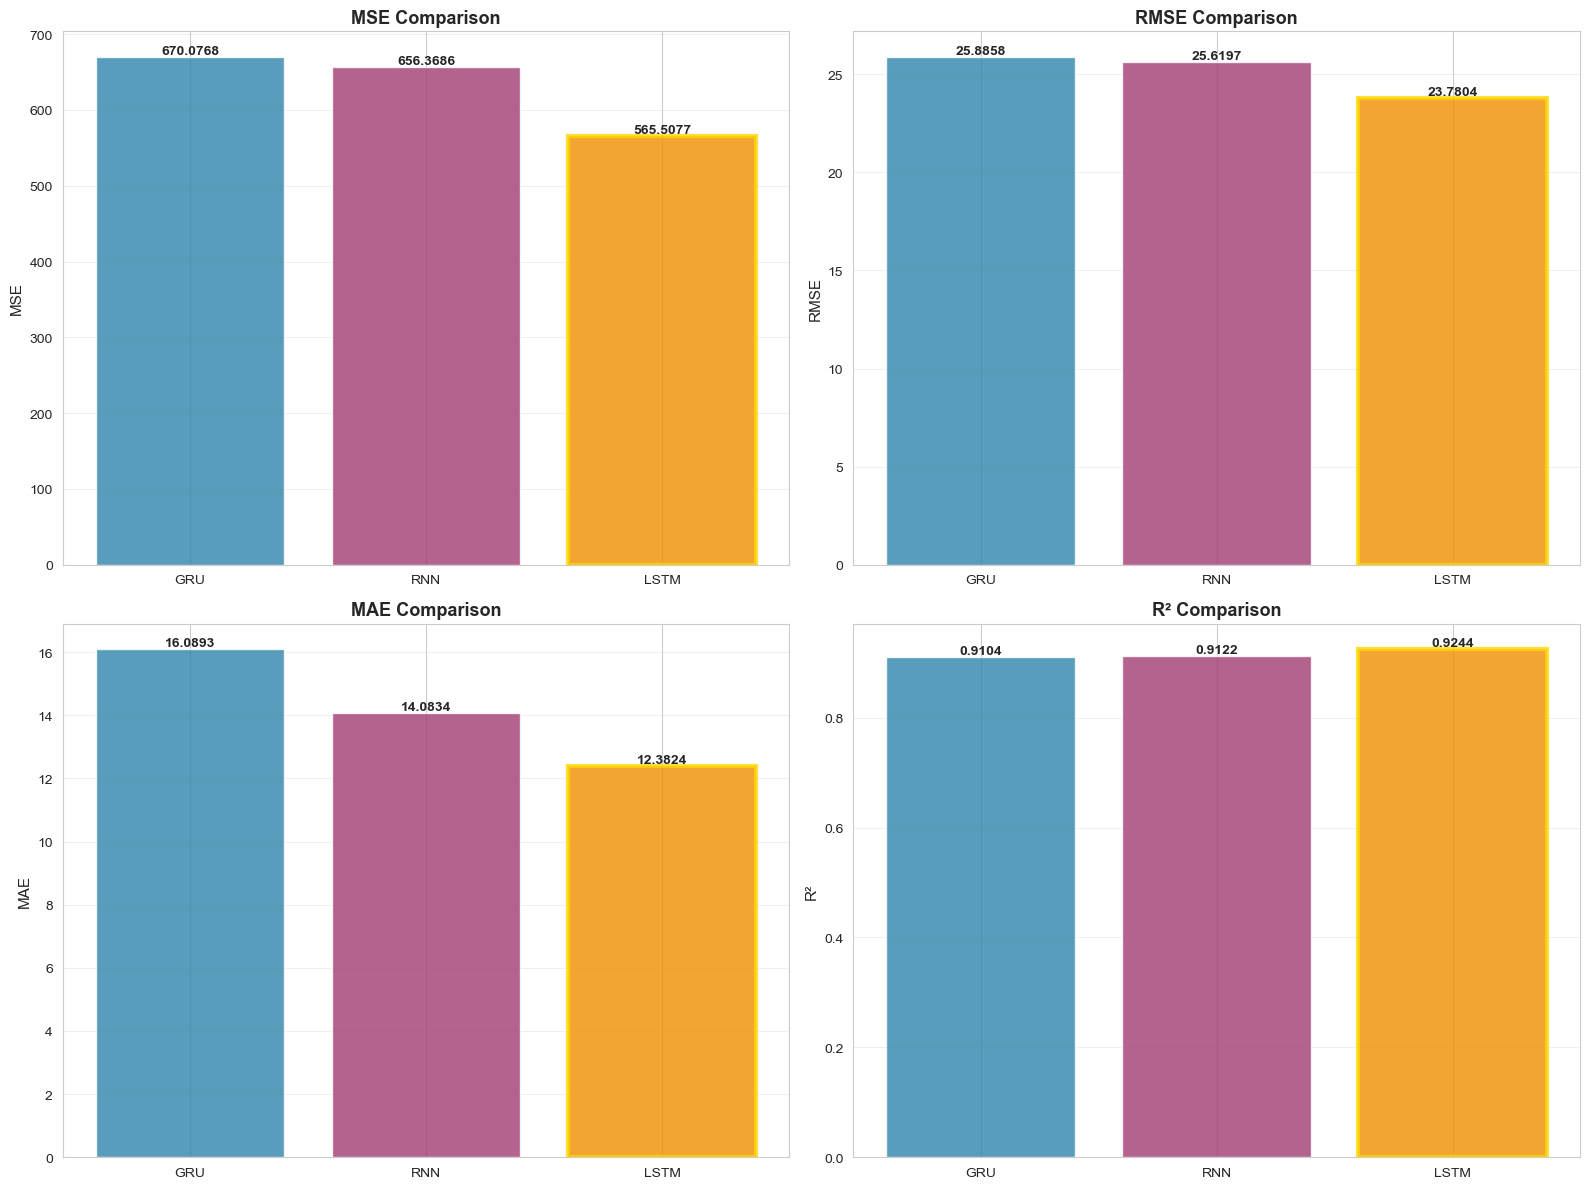

In [38]:
# Visualizzazione comparativa - Metrics Bar Plot

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R²']
colors = {'GRU': '#2E86AB', 'RNN': '#A23B72', 'LSTM': '#F18F01'}

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    
    models = list(results.keys())
    values = [results[m][metric] for m in models]
    
    bars = ax.bar(models, values, color=[colors.get(m, '#999999') for m in models], alpha=0.8)
    
    # Evidenzia miglior modello
    if metric != 'R²':
        best_idx = np.argmin(values)
    else:
        best_idx = np.argmax(values)
    bars[best_idx].set_edgecolor('gold')
    bars[best_idx].set_linewidth(3)
    
    ax.set_title(f'{metric} Comparison', fontsize=13, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Annota valori
    for i, v in enumerate(values):
        ax.text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()

# Salva figura
fig_path = Path('../figures/prediction')
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'model_comparison_metrics.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Metrics comparison salvata: {fig_path / 'model_comparison_metrics.pdf'}")

plt.show()

✓ Predicted vs Actual salvata: ../figures/prediction/predicted_vs_actual_comparison.pdf


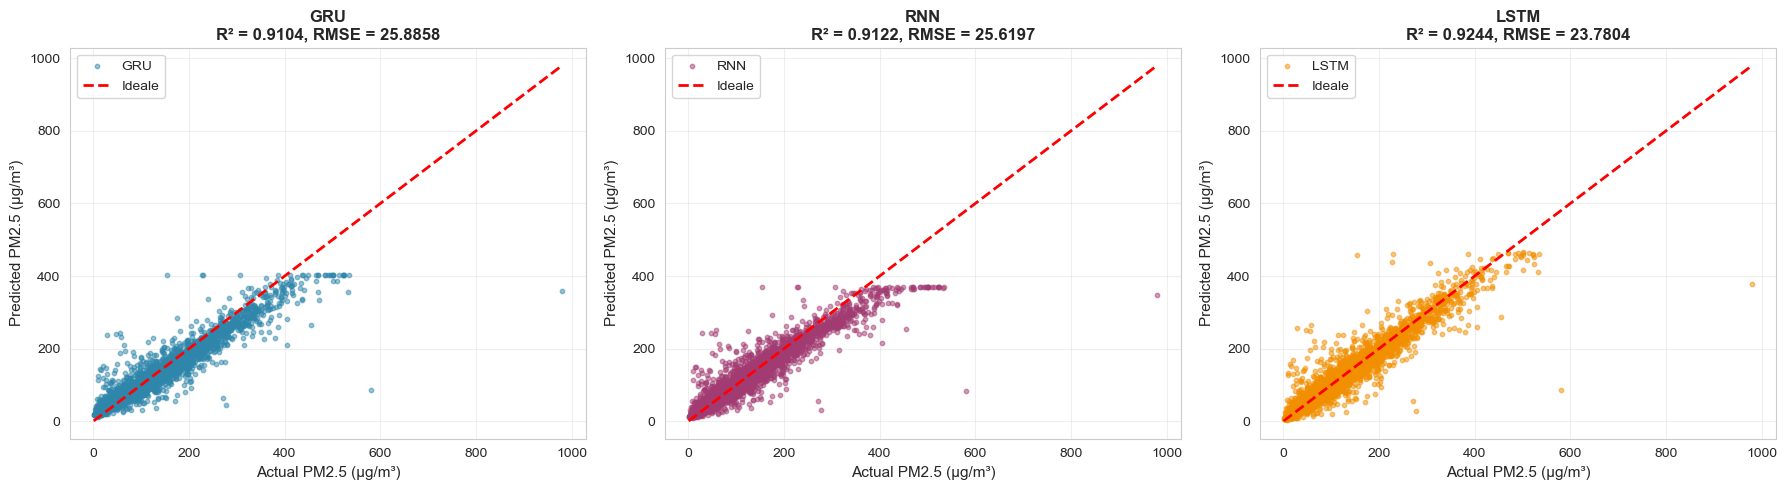

In [39]:
# Scatter plot: Predicted vs Actual (tutti i modelli)

fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))

if len(results) == 1:
    axes = [axes]

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx]
    
    # Scatter plot
    ax.scatter(y_test, data['predictions'], alpha=0.5, s=10, 
               color=colors.get(model_name, '#999999'), label=model_name)
    
    # Linea ideale (y = x)
    min_val = min(y_test.min(), data['predictions'].min())
    max_val = max(y_test.max(), data['predictions'].max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Ideale')
    
    ax.set_xlabel('Actual PM2.5 (μg/m³)', fontsize=11)
    ax.set_ylabel('Predicted PM2.5 (μg/m³)', fontsize=11)
    ax.set_title(f'{model_name}\nR² = {data["R²"]:.4f}, RMSE = {data["RMSE"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'predicted_vs_actual_comparison.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Predicted vs Actual salvata: {fig_path / 'predicted_vs_actual_comparison.pdf'}")

plt.show()

✓ Residual plots salvati: ../figures/prediction/residual_plots_comparison.pdf


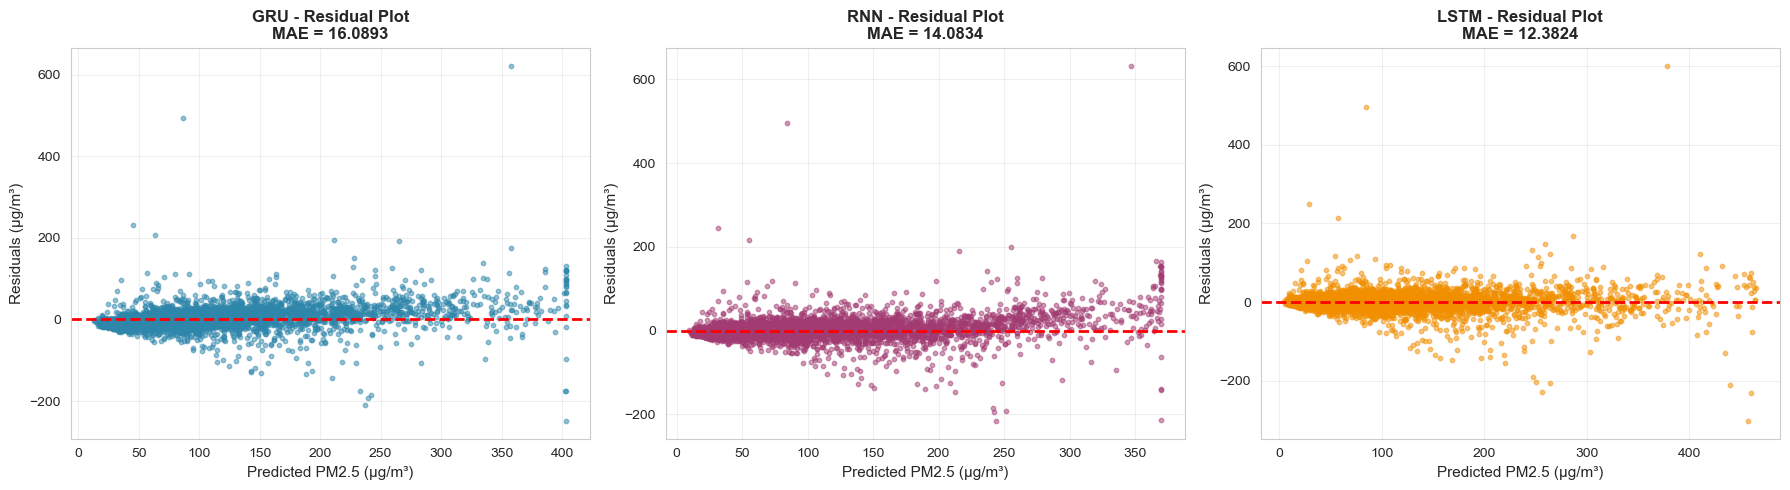

In [40]:
# Residual plots (tutti i modelli)

fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))

if len(results) == 1:
    axes = [axes]

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx]
    
    residuals = y_test.flatten() - data['predictions']
    
    # Scatter plot residui
    ax.scatter(data['predictions'], residuals, alpha=0.5, s=10,
               color=colors.get(model_name, '#999999'))
    
    # Linea zero
    ax.axhline(y=0, color='r', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Predicted PM2.5 (μg/m³)', fontsize=11)
    ax.set_ylabel('Residuals (μg/m³)', fontsize=11)
    ax.set_title(f'{model_name} - Residual Plot\nMAE = {data["MAE"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'residual_plots_comparison.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Residual plots salvati: {fig_path / 'residual_plots_comparison.pdf'}")

plt.show()

✓ Time series comparison salvata: ../figures/prediction/time_series_comparison.pdf


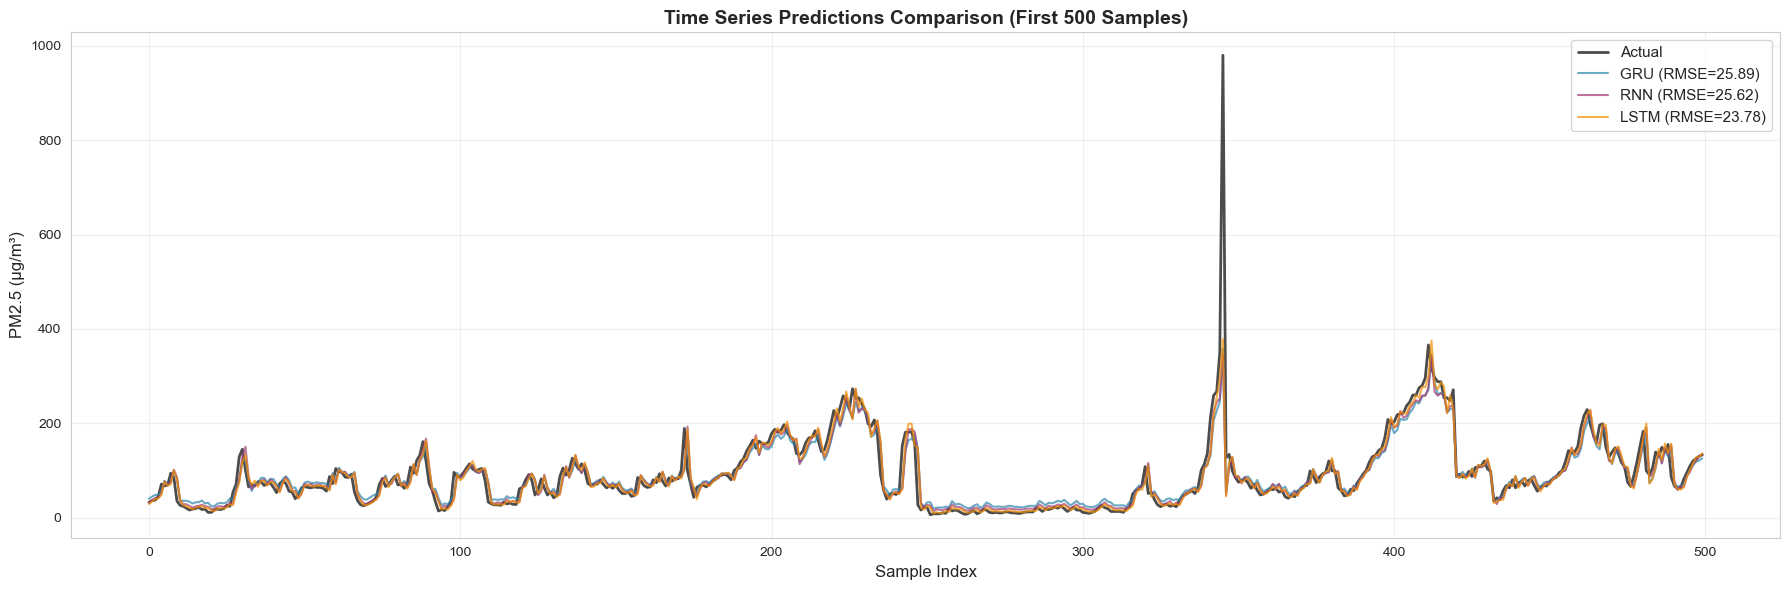

In [41]:
# Time series plot: confronto predizioni su subset del test

# Seleziona prime 500 predizioni per visualizzazione
n_samples = min(500, len(y_test))
sample_indices = range(n_samples)

fig, ax = plt.subplots(figsize=(18, 6))

# Plot actual values
ax.plot(sample_indices, y_test.flatten()[:n_samples], 
        label='Actual', color='black', linewidth=2, alpha=0.7)

# Plot predizioni di ogni modello
for model_name, data in results.items():
    ax.plot(sample_indices, data['predictions'][:n_samples],
            label=f'{model_name} (RMSE={data["RMSE"]:.2f})',
            color=colors.get(model_name, '#999999'),
            linewidth=1.5, alpha=0.7)

ax.set_xlabel('Sample Index', fontsize=12)
ax.set_ylabel('PM2.5 (μg/m³)', fontsize=12)
ax.set_title('Time Series Predictions Comparison (First 500 Samples)', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'time_series_comparison.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Time series comparison salvata: {fig_path / 'time_series_comparison.pdf'}")

plt.show()

✓ Error distribution salvata: ../figures/prediction/error_distribution_comparison.pdf


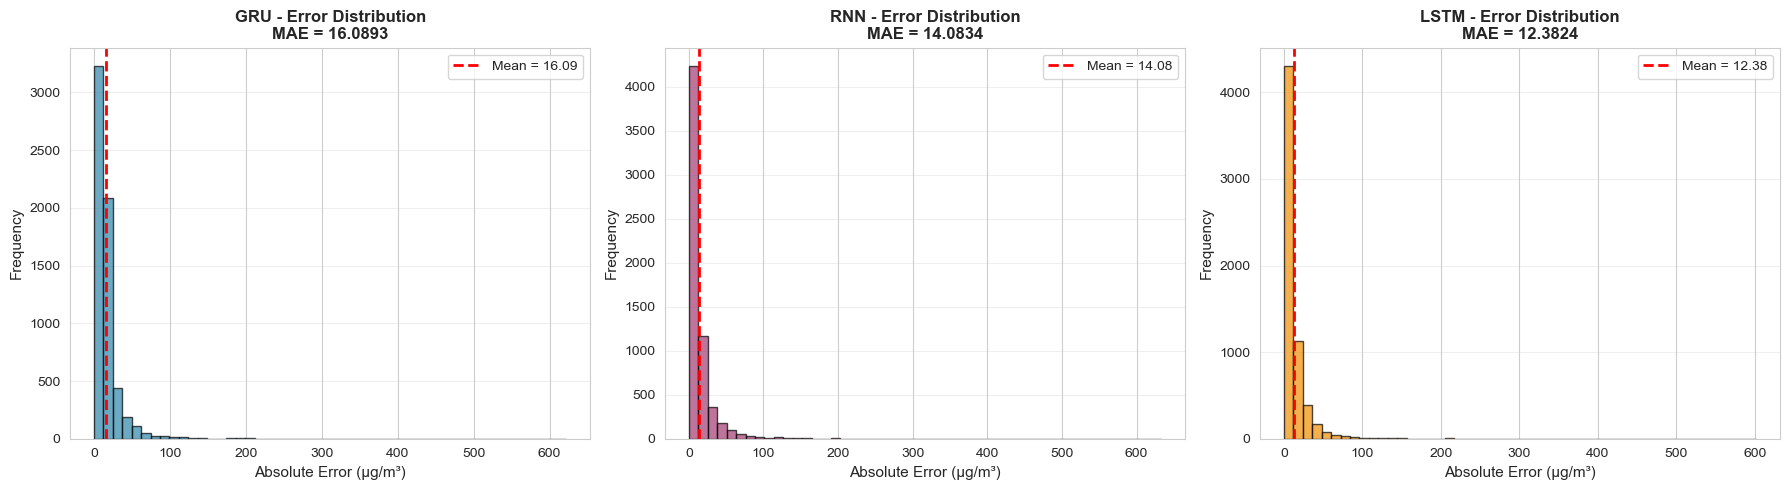

In [42]:
# Error distribution comparison

fig, axes = plt.subplots(1, len(results), figsize=(6*len(results), 5))

if len(results) == 1:
    axes = [axes]

for idx, (model_name, data) in enumerate(results.items()):
    ax = axes[idx]
    
    errors = np.abs(y_test.flatten() - data['predictions'])
    
    # Histogram
    ax.hist(errors, bins=50, color=colors.get(model_name, '#999999'), 
            alpha=0.7, edgecolor='black')
    
    # Linea media
    mean_error = np.mean(errors)
    ax.axvline(mean_error, color='red', linestyle='--', linewidth=2, 
               label=f'Mean = {mean_error:.2f}')
    
    ax.set_xlabel('Absolute Error (μg/m³)', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'{model_name} - Error Distribution\nMAE = {data["MAE"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(fig_path / 'error_distribution_comparison.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Error distribution salvata: {fig_path / 'error_distribution_comparison.pdf'}")

plt.show()

✓ Training history salvata: ../figures/prediction/training_history_comparison.pdf


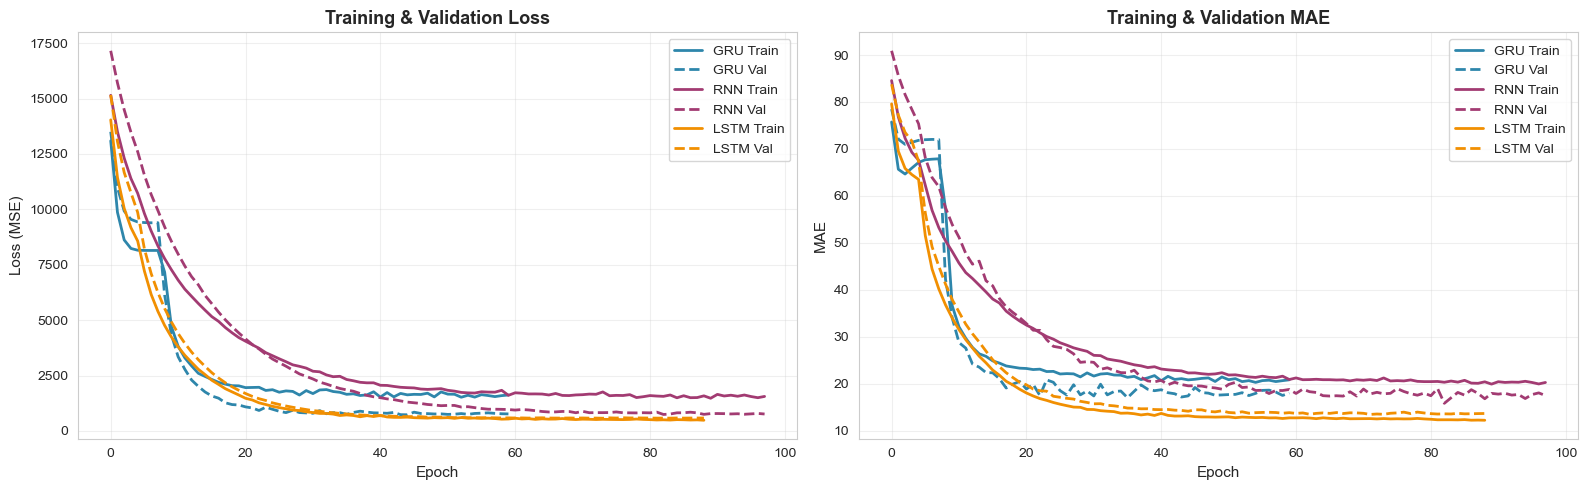

In [44]:
# Training history comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss comparison
ax = axes[0]
ax.plot(gru_history['loss'], label='GRU Train', color=colors['GRU'], linewidth=2)
ax.plot(gru_history['val_loss'], label='GRU Val', color=colors['GRU'], 
        linewidth=2, linestyle='--')
ax.plot(rnn_history['loss'], label='RNN Train', color=colors['RNN'], linewidth=2)
ax.plot(rnn_history['val_loss'], label='RNN Val', color=colors['RNN'], 
        linewidth=2, linestyle='--')
ax.plot(lstm_history['loss'], label='LSTM Train', color=colors['LSTM'], linewidth=2)
ax.plot(lstm_history['val_loss'], label='LSTM Val', color=colors['LSTM'], 
        linewidth=2, linestyle='--')

ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss (MSE)', fontsize=11)
ax.set_title('Training & Validation Loss', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# MAE comparison
ax = axes[1]
ax.plot(gru_history['mae'], label='GRU Train', color=colors['GRU'], linewidth=2)
ax.plot(gru_history['val_mae'], label='GRU Val', color=colors['GRU'], 
        linewidth=2, linestyle='--')
ax.plot(rnn_history['mae'], label='RNN Train', color=colors['RNN'], linewidth=2)
ax.plot(rnn_history['val_mae'], label='RNN Val', color=colors['RNN'], 
        linewidth=2, linestyle='--')
ax.plot(lstm_history['mae'], label='LSTM Train', color=colors['LSTM'], linewidth=2)
ax.plot(lstm_history['val_mae'], label='LSTM Val', color=colors['LSTM'], 
        linewidth=2, linestyle='--')

ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('MAE', fontsize=11)
ax.set_title('Training & Validation MAE', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(fig_path / 'training_history_comparison.pdf', dpi=150, bbox_inches='tight')
print(f"✓ Training history salvata: {fig_path / 'training_history_comparison.pdf'}")

plt.show()

In [45]:
# Summary finale

print("\n" + "="*70)
print("SUMMARY FINALE - CONFRONTO MODELLI")
print("="*70)

print("\n📊 METRICHE TEST SET:")
print(metrics_df.to_string())

print(f"\n\n🏆 MIGLIOR MODELLO: {best_model}")
print(f"   • RMSE: {metrics_df.loc[best_model, 'RMSE']:.4f}")
print(f"   • MAE:  {metrics_df.loc[best_model, 'MAE']:.4f}")
print(f"   • R²:   {metrics_df.loc[best_model, 'R²']:.4f}")

print("\n📈 RANKING (basato su RMSE):")
ranking = metrics_df.sort_values('RMSE')
for i, (model, row) in enumerate(ranking.iterrows(), 1):
    print(f"   {i}. {model:<8} - RMSE: {row['RMSE']:.4f}")

print("\n💾 FILE SALVATI:")
print(f"   • GRU model:     {gru_model_path.name}")
print(f"   • RNN model:     {rnn_model_path.name}")
print(f"   • Visualizzazioni in: {fig_path}")

print("\n" + "="*70)


SUMMARY FINALE - CONFRONTO MODELLI

📊 METRICHE TEST SET:
           MSE     RMSE      MAE      R²
GRU   670.0768  25.8858  16.0893  0.9104
RNN   656.3686  25.6197  14.0834  0.9122
LSTM  565.5077  23.7804  12.3824  0.9244


🏆 MIGLIOR MODELLO: LSTM
   • RMSE: 23.7804
   • MAE:  12.3824
   • R²:   0.9244

📈 RANKING (basato su RMSE):
   1. LSTM     - RMSE: 23.7804
   2. RNN      - RMSE: 25.6197
   3. GRU      - RMSE: 25.8858

💾 FILE SALVATI:
   • GRU model:     gru_pm25_forecaster.h5
   • RNN model:     rnn_pm25_forecaster.h5
   • Visualizzazioni in: ../figures/prediction

